<a href="https://colab.research.google.com/github/sowmyamanojna/CS6024-Algorithmic-Approaches-to-Computational-Biology-Project/blob/master/codes/integrate_compression_hetnet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Create a hetnet of genesets for automatic gene expression compression interpretation

This script was modified from https://github.com/dhimmel/integrate.

The script creates a hetnet as described in the eLIFE publication _"Systematic integration of biomedical knowledge prioritizes drugs for repurposing"_ by [Himmelstein et al. 2017](https://doi.org/10.7554/eLife.26726)

## Datasets

1. [MSigDb](https://doi.org/10.1073/pnas.0506580102 "Gene set enrichment analysis: A knowledge-based approach for interpreting genome-wide expression profiles") - Curated genesets that represent various biological processes
2. [xCell](https://doi.org/10.1186/s13059-017-1349-1, "xCell: digitally portraying the tissue cellular heterogeneity landscape") - Curated genesets that describe profiles of different cell-types

In [1]:
! pip install hetio

import os
import csv
import numpy as np
import pandas as pd
import seaborn as sns

import hetio.hetnet
import hetio.readwrite
import hetio.stats

/usr/local/lib/python3.6/dist-packages/hetio/__init__.py:11: FutureWarning: 
PACKAGE HAS BEEN RELOCATED:
v0.2.11 is the last release before the hetio package is renamed to hetnetpy.
Consider switching to the hetnetpy package or specifying hetio<=0.2.10 to silence this warning.
Future releases and development will only occur for the hetnetpy package.

  warnings.warn(message, FutureWarning)


In [2]:
%matplotlib inline

In [3]:
from google.colab import drive
drive.mount("/content/drive/")

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


## Define the metagraph and instantiate the graph

In [4]:
kind_to_abbev = {
    
    # metanodes
    'Gene': 'G',

    # MSigDB Nodes
    'Hallmarks': 'H',
    'Positional-Gene-Sets': 'C1',
    'Curated-Gene-Sets-CPG': 'C2CPG',
    'Curated-Gene-Sets-REACTOME': 'C2CPREACTOME',
    'Motif-Gene-Sets-MIR': 'C3MIR',
    'Motif-Gene-Sets-TFT': 'C3TFT',
    'Computational-Gene-Sets-CGN': 'C4CGN',
    'Computational-Gene-Sets-CM': 'C4CM',
    'GO-Gene-Sets-BP': 'C5BP',
    'GO-Gene-Sets-CC': 'C5CC',
    'GO-Gene-Sets-MF': 'C5MF',
    'Oncogenic-Gene-Sets': 'C6',
    'Immunologic-Gene-Sets': 'C7',
    
    # xCell Nodes
    'xCell-Cell-Type': 'XCELL',
    
    # metaedges
    'participates': 'p',
}

metaedge_tuples = [
    # MSigDB metaedges
    ('Gene', 'Hallmarks', 'participates', 'both'),
    ('Gene', 'Positional-Gene-Sets', 'participates', 'both'),
    ('Gene', 'Curated-Gene-Sets-CPG', 'participates', 'both'),
    ('Gene', 'Curated-Gene-Sets-REACTOME', 'participates', 'both'),
    ('Gene', 'Motif-Gene-Sets-MIR', 'participates', 'both'),
    ('Gene', 'Motif-Gene-Sets-TFT', 'participates', 'both'),
    ('Gene', 'Computational-Gene-Sets-CGN', 'participates', 'both'),
    ('Gene', 'Computational-Gene-Sets-CM', 'participates', 'both'),
    ('Gene', 'GO-Gene-Sets-BP', 'participates', 'both'),
    ('Gene', 'GO-Gene-Sets-CC', 'participates', 'both'),
    ('Gene', 'GO-Gene-Sets-MF', 'participates', 'both'),
    ('Gene', 'Oncogenic-Gene-Sets', 'participates', 'both'),
    ('Gene', 'Immunologic-Gene-Sets', 'participates', 'both'),
    
    # xCell metaedges
    ('Gene', 'xCell-Cell-Type', 'participates', 'both'),
]

In [5]:
# Initialize the graph
metagraph = hetio.hetnet.MetaGraph.from_edge_tuples(metaedge_tuples, kind_to_abbev)
graph = hetio.hetnet.Graph(metagraph)

## Gene Nodes
Adding the `unique_mapping_ids` here, for making it more relate to our project.

In [6]:
data = pd.read_csv("/content/drive/MyDrive/aacb_project/datasets/common_normalized.csv", index_col=0)
columns = data.columns[1:-1]
columns = list(columns)
pcos_ids = []
for i in columns:
    if len(i.split("_")) == 1 and int(i) not in pcos_ids:
        pcos_ids.append(int(i))
    else:
        for j in i.split("_"):
            if int(j) not in pcos_ids:
                pcos_ids.append(int(j))

print(len(pcos_ids))

1681


In [7]:
# Load curated gene names from versioned resource 
commit = '721204091a96e55de6dcad165d6d8265e67e2a48'
url = 'https://raw.githubusercontent.com/cognoma/genes/{}/data/genes.tsv'.format(commit)
gene_df = pd.read_table(url)

# Only consider protein-coding genes
# gene_df = (
#     gene_df.query("gene_type == 'protein-coding'")
# )

coding_genes = set(gene_df['entrez_gene_id'].astype(int))
print(gene_df.shape)
gene_df

(60139, 7)


,entrez_gene_id,symbol,description,chromosome,gene_type,synonyms,aliases
0,1,A1BG,alpha-1-B glycoprotein,19,protein-coding,A1B|ABG|GAB|HYST2477,alpha-1B-glycoprotein|HEL-S-163pA|epididymis s...
1,2,A2M,alpha-2-macroglobulin,12,protein-coding,A2MD|CPAMD5|FWP007|S863-7,alpha-2-macroglobulin|C3 and PZP-like alpha-2-...
2,3,A2MP1,alpha-2-macroglobulin pseudogene 1,12,pseudo,A2MP,pregnancy-zone protein pseudogene
3,9,NAT1,N-acetyltransferase 1,8,protein-coding,AAC1|MNAT|NAT-1|NATI,arylamine N-acetyltransferase 1|N-acetyltransf...
4,10,NAT2,N-acetyltransferase 2,8,protein-coding,AAC2|NAT-2|PNAT,arylamine N-acetyltransferase 2|N-acetyltransf...
...,...,...,...,...,...,...,...
60134,108684029,DUPXQ25,Xq25 duplication syndrome,X,unknown,NaN,NaN
60135,108720147,HIPSTR,Heterogeneously expressed from the Intronic Pl...,NaN,protein-coding,NaN,NaN
60136,108783645,LOC108783645,HFE antisense RNA,6,ncRNA,NaN,NaN
60137,108783646,DINO,"DNA damage, p53 is stabilized and p53-responsive",6,ncRNA,NaN,NaN


In [8]:
# Load gene updater
url = 'https://raw.githubusercontent.com/cognoma/genes/{}/data/updater.tsv'.format(commit)
updater_df = pd.read_table(url)
old_to_new_entrez = dict(zip(updater_df.old_entrez_gene_id,
                             updater_df.new_entrez_gene_id))

In [9]:
for j,i in enumerate(old_to_new_entrez):
    print(i, old_to_new_entrez[i], type(i))
    if j>10:
        break

to_new = list(old_to_new_entrez.keys())

8 7003 <class 'int'>
42 51596 <class 'int'>
44 1261 <class 'int'>
45 54714 <class 'int'>
57 7291 <class 'int'>
61 643309 <class 'int'>
76 648740 <class 'int'>
77 100462767 <class 'int'>
96 79839 <class 'int'>
99 348 <class 'int'>
110 196883 <class 'int'>
121 120 <class 'int'>


In [10]:
for i in old_to_new_entrez:
    pos = np.where(gene_df["entrez_gene_id"] == i)[0]
    if pos.shape[0] > 0:
        print(pos)

In [11]:
not_present = []
new_change = []
present = []

for i in pcos_ids:
    if i not in gene_df["entrez_gene_id"]:
        not_present.append(i)
    elif i in to_new:
        new_change.append(i)
    elif i in gene_df["entrez_gene_id"]:
        present.append(i)

print(len(not_present))
print(len(new_change))
print(len(present))

346
0
1335


In [12]:
display(gene_df.head(2))
df = gene_df.T
df.columns = df.loc["entrez_gene_id"]
df = df[1:]

# Taking only those entries that is present in PCOS
df_new = df[present]
df_new = df_new.T.reset_index()
display(df_new.head(2))

,entrez_gene_id,symbol,description,chromosome,gene_type,synonyms,aliases
0,1,A1BG,alpha-1-B glycoprotein,19,protein-coding,A1B|ABG|GAB|HYST2477,alpha-1B-glycoprotein|HEL-S-163pA|epididymis s...
1,2,A2M,alpha-2-macroglobulin,12,protein-coding,A2MD|CPAMD5|FWP007|S863-7,alpha-2-macroglobulin|C3 and PZP-like alpha-2-...


,entrez_gene_id,symbol,description,chromosome,gene_type,synonyms,aliases
0,27,ABL2,"ABL proto-oncogene 2, non-receptor tyrosine ki...",1,protein-coding,ABLL|ARG,Abelson tyrosine-protein kinase 2|abelson-rela...
1,36,ACADSB,"acyl-CoA dehydrogenase, short/branched chain",10,protein-coding,2-MEBCAD|ACAD7|SBCAD,short/branched chain specific acyl-CoA dehydro...


## Add genes as nodes to the graph

Use the gene-symbol identifier for easier interpretation

In [13]:
%%time
for i, row in df_new.iterrows():
    # Build dictionary of descriptive elements for each gene
    meta_data = {
        'description': row['description'],
        'source': 'Entrez Gene',
        'url': 'http://identifiers.org/ncbigene/{}'.format(row['entrez_gene_id']),
        'license': 'CC0 1.0',
    }
    
    if pd.notnull(row['chromosome']):
        meta_data['chromosome'] = row['chromosome']

    # Add genes to graph
    graph.add_node(kind='Gene', identifier=int(row['entrez_gene_id']), name=row['symbol'],
                   data=meta_data)

CPU times: user 162 ms, sys: 320 µs, total: 162 ms
Wall time: 162 ms


## Add gene set nodes and associated genes as edges

Add each MSigDB collection as distinct nodes with a `participates` edge for representative gene sets and corresponding membership.

In [14]:
def add_node_to_graph(current_graph, collection_file, collection_kind,
                      collection_source, gene_list, min_geneset_size=4,
                      max_geneset_size=1000, license='CC BY 4.0'):
    """
    Add nodes and edges to current graph based on geneset memembership of collection
    
    Arguments:
    current_graph - a hetnet object to add node-edge info to
    collection_file - location of msigdb file
    collection_kind - the kind of node already initialized in the graph
    collection_source - alternative ID for collection
    gene_list - a list of genes to consider when building the graph
    min_geneset_size - filter out a given gene set if it has fewer genes
    max_geneset_size - filter out a given gene set if it has more genes
    license - given license associated with node
    
    Output:
    Adds to current graph; Returns the amount of filtered genesets
    """
    
    # Build meta data dictionary to store node info
    meta_data = {'license': license, 'source': collection_source}
    
    # Open the .gmt file and process each geneset
    filtered_genesets = []
    with open(collection_file, 'r') as collection_fh:
        collection_reader = csv.reader(collection_fh, delimiter='\t')

        for row in collection_reader:
            # Get geneset and and metadata info
            geneset_name = row[0]
            meta_data['url'] = row[1]
            
            # Process geneset membership
            genes = row[2:]

            # Update entrez_gene_id
            genes = set(old_to_new_entrez[x] if x in old_to_new_entrez else x for x in genes)
            
            # The genes must exist in curated resource
            genes = [int(x) for x in genes if int(x) in gene_list]

            # Filter geneset if its too big or small
            if min_geneset_size > len(genes) or len(genes) > max_geneset_size:
                filtered_genesets.append(geneset_name)
                continue
                
            # Add the genesetname as a node (based on collection) to the graph
            current_graph.add_node(kind=collection_kind,
                                   identifier=geneset_name,
                                   data=meta_data)
            # Loop through all genes and add to the graph it should be considered
            for gene in genes:
                source_id = ('Gene', gene)
                target_id = (collection_kind, geneset_name)
                edge_data = meta_data.copy()
                current_graph.add_edge(source_id, target_id, 'participates',
                                       'both', edge_data)

    return filtered_genesets

In [15]:
hetnet_build = {
    # Format: `Collection Source`: [`Collection File`, `Collection Kind`]

    # MSigDB
    'MSigDB-H': ['h.all.v6.1.entrez.gmt', 'Hallmarks'],
    'MSigDB-C1': ['c1.all.v6.1.entrez.gmt', 'Positional-Gene-Sets'],
    'MSigDB-C2-CPG': ['c2.cgp.v6.1.entrez.gmt', 'Curated-Gene-Sets-CPG'],
    'MSigDB-C2-Reactome': ['c2.cp.reactome.v6.1.entrez.gmt', 'Curated-Gene-Sets-REACTOME'],
    'MSigDB-C3-MIR': ['c3.mir.v6.1.entrez.gmt', 'Motif-Gene-Sets-MIR'],
    'MSigDB-C3-TFT': ['c3.tft.v6.1.entrez.gmt', 'Motif-Gene-Sets-TFT'],
    'MSigDB-C4-CGN': ['c4.cgn.v6.1.entrez.gmt', 'Computational-Gene-Sets-CGN'],
    'MSigDB-C4-CM': ['c4.cm.v6.1.entrez.gmt', 'Computational-Gene-Sets-CM'],
    'MSigDB-C5-BP': ['c5.bp.v6.1.entrez.gmt', 'GO-Gene-Sets-BP'],
    'MSigDB-C5-CC': ['c5.cc.v6.1.entrez.gmt', 'GO-Gene-Sets-CC'],
    'MSigDB-C5-MF': ['c5.mf.v6.1.entrez.gmt', 'GO-Gene-Sets-MF'],
    'MSigDB-C6': ['c6.all.v6.1.entrez.gmt', 'Oncogenic-Gene-Sets'],
    'MSigDB-C7': ['c7.all.v6.1.entrez.gmt', 'Immunologic-Gene-Sets'],
    
    # xCell
    'xCell-X': ['xcell_all_entrez.gmt', 'xCell-Cell-Type'],

}

In [16]:
%%time
# Add all collections genesets to hetnet
filtered = {}
for collection_source, collection_info in hetnet_build.items():
    print(collection_source)
    path, collection_kind = collection_info
    collection_file = os.path.join('/content/drive/MyDrive/aacb_project/data', path)
    filtered[collection_kind] = add_node_to_graph(current_graph=graph,
                                                  collection_file=collection_file,
                                                  collection_kind=collection_kind,
                                                  collection_source=collection_source,
                                                  gene_list=present)
# The change here being gene_list = present
# from gene_list=coding_genes

MSigDB-H
MSigDB-C1
MSigDB-C2-CPG
MSigDB-C2-Reactome
MSigDB-C3-MIR
MSigDB-C3-TFT
MSigDB-C4-CGN
MSigDB-C4-CM
MSigDB-C5-BP
MSigDB-C5-CC
MSigDB-C5-MF
MSigDB-C6
MSigDB-C7
xCell-X
CPU times: user 36.1 s, sys: 143 ms, total: 36.3 s
Wall time: 36.9 s


## Network visualizations and stats

In [18]:
# Export node degree tables
node_degree_file = os.path.join('/content/drive/MyDrive/aacb_project/results', 'interpret_node_degrees.xlsx')
hetio.stats.degrees_to_excel(graph, node_degree_file)

In [20]:
# Summary of metanodes and cooresponding nodes
metanode_df = hetio.stats.get_metanode_df(graph)

metanode_file = os.path.join('/content/drive/MyDrive/aacb_project/results', 'interpret_metanode_summary.tsv')
metanode_df.to_csv(metanode_file, sep='\t', index=False)
metanode_df

,metanode,abbreviation,metaedges,nodes,unconnected_nodes
7,Computational-Gene-Sets-CGN,C4CGN,1,338,0
8,Computational-Gene-Sets-CM,C4CM,1,238,0
3,Curated-Gene-Sets-CPG,C2CPG,1,1937,0
4,Curated-Gene-Sets-REACTOME,C2CPREACTOME,1,284,0
9,GO-Gene-Sets-BP,C5BP,1,2207,0
10,GO-Gene-Sets-CC,C5CC,1,314,0
11,GO-Gene-Sets-MF,C5MF,1,414,0
0,Gene,G,14,1335,0
1,Hallmarks,H,1,45,0
13,Immunologic-Gene-Sets,C7,1,4868,0


In [22]:
# Summary of metaedges and cooresponding edges
metaedge_df = hetio.stats.get_metaedge_df(graph)

rows = list()
for metaedge, edges in graph.get_metaedge_to_edges(exclude_inverts=True).items():
    rows.append({'metaedge': str(metaedge)})

metaedge_file = os.path.join('/content/drive/MyDrive/aacb_project/results', 'interpret_metaedges.tsv')
metaedge_df = metaedge_df.merge(pd.DataFrame(rows))

sum_total = metaedge_df.sum()
sum_total.metaedge = 'Total'
sum_total.abbreviation = ''

metaedge_df = (
    pd.concat([metaedge_df.T, sum_total], axis='columns')
    .transpose()
    .reset_index(drop=True)
)
# Number of edges in the network
metaedge_df.edges.sum()

metaedge_df.to_csv(metaedge_file, sep='\t', index=False)
metaedge_df

,metaedge,abbreviation,edges,source_nodes,target_nodes
0,Gene - participates - Computational-Gene-Sets-CGN,GpC4CGN,4909,492,338
1,Gene - participates - Computational-Gene-Sets-CM,GpC4CM,4043,766,238
2,Gene - participates - Curated-Gene-Sets-CPG,GpC2CPG,35712,1333,1937
3,Gene - participates - Curated-Gene-Sets-REACTOME,GpC2CPREACTOME,2884,492,284
4,Gene - participates - GO-Gene-Sets-BP,GpC5BP,43739,1216,2207
5,Gene - participates - GO-Gene-Sets-CC,GpC5CC,7960,1004,314
6,Gene - participates - GO-Gene-Sets-MF,GpC5MF,7963,1129,414
7,Gene - participates - Hallmarks,GpH,718,449,45
8,Gene - participates - Immunologic-Gene-Sets,GpC7,88785,1334,4868
9,Gene - participates - Motif-Gene-Sets-MIR,GpC3MIR,4143,741,194


In [23]:
# Summary of different styles for representing each metaedge
metaedge_style_file = os.path.join('/content/drive/MyDrive/aacb_project/results', 'interpret_metaedge_styles.tsv')
metaedge_style_df = hetio.stats.get_metaedge_style_df(metagraph)
metaedge_style_df.to_csv(metaedge_style_file, sep='\t', index=False)
metaedge_style_df

,metaedge,unicode_metaedge,standard_metaedge,abbreviation,standard_abbreviation,source,target,inverted
13,Computational-Gene-Sets-CGN - participates - Gene,Computational-Gene-Sets-CGN–participates–Gene,Gene - participates - Computational-Gene-Sets-CGN,C4CGNpG,GpC4CGN,Computational-Gene-Sets-CGN,Gene,1
15,Computational-Gene-Sets-CM - participates - Gene,Computational-Gene-Sets-CM–participates–Gene,Gene - participates - Computational-Gene-Sets-CM,C4CMpG,GpC4CM,Computational-Gene-Sets-CM,Gene,1
5,Curated-Gene-Sets-CPG - participates - Gene,Curated-Gene-Sets-CPG–participates–Gene,Gene - participates - Curated-Gene-Sets-CPG,C2CPGpG,GpC2CPG,Curated-Gene-Sets-CPG,Gene,1
7,Curated-Gene-Sets-REACTOME - participates - Gene,Curated-Gene-Sets-REACTOME–participates–Gene,Gene - participates - Curated-Gene-Sets-REACTOME,C2CPREACTOMEpG,GpC2CPREACTOME,Curated-Gene-Sets-REACTOME,Gene,1
17,GO-Gene-Sets-BP - participates - Gene,GO-Gene-Sets-BP–participates–Gene,Gene - participates - GO-Gene-Sets-BP,C5BPpG,GpC5BP,GO-Gene-Sets-BP,Gene,1
19,GO-Gene-Sets-CC - participates - Gene,GO-Gene-Sets-CC–participates–Gene,Gene - participates - GO-Gene-Sets-CC,C5CCpG,GpC5CC,GO-Gene-Sets-CC,Gene,1
21,GO-Gene-Sets-MF - participates - Gene,GO-Gene-Sets-MF–participates–Gene,Gene - participates - GO-Gene-Sets-MF,C5MFpG,GpC5MF,GO-Gene-Sets-MF,Gene,1
12,Gene - participates - Computational-Gene-Sets-CGN,Gene–participates–Computational-Gene-Sets-CGN,Gene - participates - Computational-Gene-Sets-CGN,GpC4CGN,GpC4CGN,Gene,Computational-Gene-Sets-CGN,0
14,Gene - participates - Computational-Gene-Sets-CM,Gene–participates–Computational-Gene-Sets-CM,Gene - participates - Computational-Gene-Sets-CM,GpC4CM,GpC4CM,Gene,Computational-Gene-Sets-CM,0
4,Gene - participates - Curated-Gene-Sets-CPG,Gene–participates–Curated-Gene-Sets-CPG,Gene - participates - Curated-Gene-Sets-CPG,GpC2CPG,GpC2CPG,Gene,Curated-Gene-Sets-CPG,0


In [24]:
# How many genesets were filtered per collection?
{x: len(y) for x, y in filtered.items()}

{'Computational-Gene-Sets-CGN': 89,
 'Computational-Gene-Sets-CM': 193,
 'Curated-Gene-Sets-CPG': 1472,
 'Curated-Gene-Sets-REACTOME': 390,
 'GO-Gene-Sets-BP': 2229,
 'GO-Gene-Sets-CC': 266,
 'GO-Gene-Sets-MF': 487,
 'Hallmarks': 5,
 'Immunologic-Gene-Sets': 4,
 'Motif-Gene-Sets-MIR': 27,
 'Motif-Gene-Sets-TFT': 19,
 'Oncogenic-Gene-Sets': 7,
 'Positional-Gene-Sets': 234,
 'xCell-Cell-Type': 319}

## Save graph

In [25]:
%%time
# Write nodes to a table
nodes_file = os.path.join('/content/drive/MyDrive/aacb_project/hetnets', 'interpret_nodes.tsv')
hetio.readwrite.write_nodetable(graph, nodes_file)

# Write edges to a table
edges_file = os.path.join('/content/drive/MyDrive/aacb_project/hetnets', 'interpret_edges.sif.gz')
hetio.readwrite.write_sif(graph, edges_file)

CPU times: user 1.61 s, sys: 2.87 ms, total: 1.61 s
Wall time: 1.63 s


In [26]:
%%time
# Write metagraph as json
metagraph_file = os.path.join('/content/drive/MyDrive/aacb_project/hetnets', 'interpret_metagraph.json')
hetio.readwrite.write_metagraph(metagraph, metagraph_file)

CPU times: user 1.16 ms, sys: 7 µs, total: 1.17 ms
Wall time: 6.05 ms


In [27]:
%%time
# Write graph as json
hetnet_json_path = os.path.join('/content/drive/MyDrive/aacb_project/hetnets', 'interpret_hetnet.json.bz2')
hetio.readwrite.write_graph(graph, hetnet_json_path)

CPU times: user 25.6 s, sys: 80.4 ms, total: 25.7 s
Wall time: 25.7 s


In [28]:
! sha256sum '/content/drive/MyDrive/aacb_project/hetnets/interpret_hetnet.json.bz2'

0e85273530eff498d07f54cb3987eb9e3cf2415f4204a88a5f5e9d1c4cace894  /content/drive/MyDrive/aacb_project/hetnets/interpret_hetnet.json.bz2


## Visualize hetnet node and edge counts

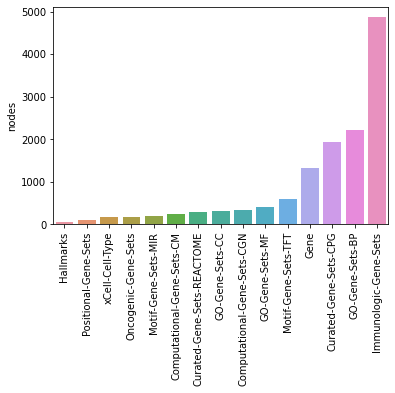

In [29]:
ax = sns.barplot(x='metanode', y='nodes', data=metanode_df.sort_values('nodes'))
for tick in ax.get_xticklabels():
    tick.set_rotation(90)
ax.set_xlabel(''); ax.set_ylabel('nodes');

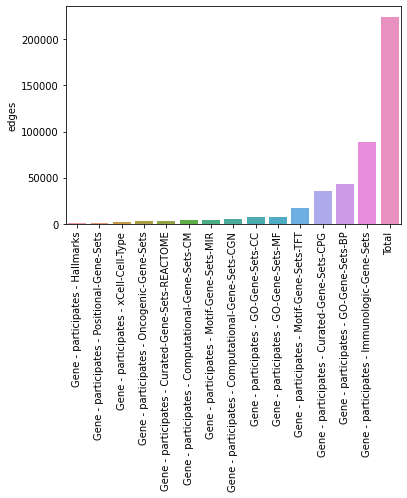

In [30]:
ax = sns.barplot(x='metaedge', y='edges', data=metaedge_df.sort_values('edges'))
for tick in ax.get_xticklabels():
    tick.set_rotation(90)
ax.set_xlabel(''); ax.set_ylabel('edges');